In [ ]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import pyarrow as pa
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import lightgbm as lgb
!pip install langdetect
from langdetect import detect
import math

     |████████████████████████████████| 981 kB 5.1 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=98d97018aba4051c36c914ddad3ea3ce7cbb4691ee5a3f65645c7a20720ebe69
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
# working with lightgbm on colab
!git clone — recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install — precompile

fatal: Too many arguments.

usage: git clone [<options>] [--] <repo> [<dir>]

    -v, --verbose         be more verbose
    -q, --quiet           be more quiet
    --progress            force progress reporting
    -n, --no-checkout     don't create a checkout
    --bare                create a bare repository
    --mirror              create a mirror repository (implies bare)
    -l, --local           to clone from a local repository
    --no-hardlinks        don't use local hardlinks, always copy
    -s, --shared          setup as shared repository
    --recurse-submodules[=<pathspec>]
                          initialize submodules in the clone
    -j, --jobs <n>        number of submodules cloned in parallel
    --template <template-directory>
                          directory from which templates will be used
    --reference <repo>    reference repository
    --reference-if-able <repo>
                          reference repository
    --dissociate          use --reference only 

In [ ]:
train_url = "/content/drive/MyDrive/IE 7275 Project_YT/Data/train.parquet"
#test_url = "/content/drive/MyDrive/IE 7275 Project_YT/Data/test.parquet"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pq.read_pandas(train_url).to_pandas()
train.dtypes

video_id                          object
title                             object
publishedAt          datetime64[ns, UTC]
channelId                         object
channelTitle                      object
categoryId                         int64
trending_date                     object
tags                              object
view_count                         int64
likes                              int64
dislikes                           int64
comment_count                      int64
thumbnail_link                    object
comments_disabled                   bool
ratings_disabled                    bool
description                       object
id                                object
duration_seconds                 float64
has_thumbnail                       bool
target                           float64
dtype: object

# Preprocessing data
- Drop features from train data set that are not in the test data set “dislikes”, “comment count” 

- Remove rows of ‘Ratings_disabled’ = False

- Do something with rows with same video.id, group_by(trending_time), age of the video, how long the video has been posted ‘trending_date’ - ‘published_at’

- Transform data types:

  ‘trending_time’ to type datetime 

  ‘description’ from (string) to length of description (int)

- Transform ‘tags’ into number of tags and type of tags

- Create new feature to classify whether a video is a ‘Youtube_shorts’

- Process thumbnails (images), run PCA() on images provided


In [ ]:
#train = train.drop(['likes', 'dislikes', 'comment_count'], axis=1) # drop once
train.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,id,duration_seconds,has_thumbnail,target
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,3C66w5Z0ixs_2020-08-12,NaN,True,0.103596
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",M9Pmf9AB4Mo_2020-08-12,NaN,True,0.061611
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,J78aPJ3VyNs_2020-08-12,NaN,True,0.173523
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,kXLn3HkpjaA_2020-08-12,NaN,True,0.046804
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...,VIUo6yapDbc_2020-08-12,NaN,True,0.040753


In [ ]:
# convert has_thumbnail and comments_disabled to 0, 1
train["has_thumbnail"] = train["has_thumbnail"].astype(int)
train["comments_disabled"] = train["comments_disabled"].astype(int)

In [ ]:
ratings_disabled = train[train['ratings_disabled']==True]
train = train[train['ratings_disabled']==False]
# drop the whole column afterwards
train["ratings_disabled"] = train["ratings_disabled"].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# create new feature, age of video, transform trending date to datetime object
train['description_length'] = train['description'].str.len().fillna(0)
train['trending_date'] = pd.to_datetime(train['trending_date']) #transform trending date to datetime object
train['publishedAt'] = train['publishedAt'].dt.tz_localize(None) #get rid of time zone
train['video_age_seconds'] = (abs(train['trending_date'] - train['publishedAt'])).dt.total_seconds().astype(int)

In [ ]:
# determine whether a video is shorts or not
train['isShorts']=train['title'].str.contains('shorts')
train["isShorts"] = train["isShorts"].astype(int)

In [ ]:
# Transform ‘tags’ into number of tags and type of tags
train.loc[train['tags'] == '[None]', 'tagsCount'] = 0
train.loc[train['tags'] != '[None]', 'tagsCount'] = train['tags'].str.count('\\|')+1

In [ ]:
train = train.reset_index(drop=True) # rearrange index after dropping rows and columns
train.tags[1224] # check index

'Bandai Namco|Bandai Namco Entertainment|Video|Games'

In [ ]:
# create language column based on title of video
lan = "/content/drive/MyDrive/IE 7275 Project_YT/Data/LanguageTitle.csv"
lan = pd.read_csv(lan)
train['language'] = lan["LanguageTitle"]

In [ ]:
all_lan = lan.LanguageTitle.unique()

count = {}
like = {}
for i in range(len(train)):
  for val in all_lan:
    if val == train["language"][i]:
      if val in count.keys():
        count[val] += train["view_count"][i]
        like[val] += train["likes"][i]
      else:
        count[val] = train["view_count"][i]
        like[val] = train["likes"][i]

In [ ]:
# find top 100 most popular channels
all_channel = train.channelTitle.unique()
count_channel_view = {}
count_channel_like = {}

for i in range(len(train)):
  val = train["channelTitle"][i]
  if val in count_channel_view.keys():
    count_channel_view[val] += train["view_count"][i]
    count_channel_like[val] += train["likes"][i]
  else:
    count_channel_view[val] = train["view_count"][i]
    count_channel_like[val] = train["likes"][i]

In [ ]:
# find channels with more than a channel's average views
rst = 0
for val in count_channel_view.values():
  rst += val
count_channel_view_mean = rst / len(count_channel_view)

top_count_channel_view_mean = {}

for key, value in count_channel_view.items():
    if value >= count_channel_view_mean:
        top_count_channel_view_mean[key] = value

In [ ]:
# find top 100 most likeable channels with more than an average youtuber's views
ratio_channel = {}
for key in top_count_channel_view_mean.keys():
  ratio_channel[key] = (count_channel_like[key] / top_count_channel_view_mean[key])

top100_channels = sorted(ratio_channel, key=ratio_channel.get, reverse=True)[:100]

In [ ]:
train["is_top100_channel"] = 0
for i in range(len(train)):
  if train["channelTitle"][i] in top100_channels:
    train["is_top100_channel"][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to b

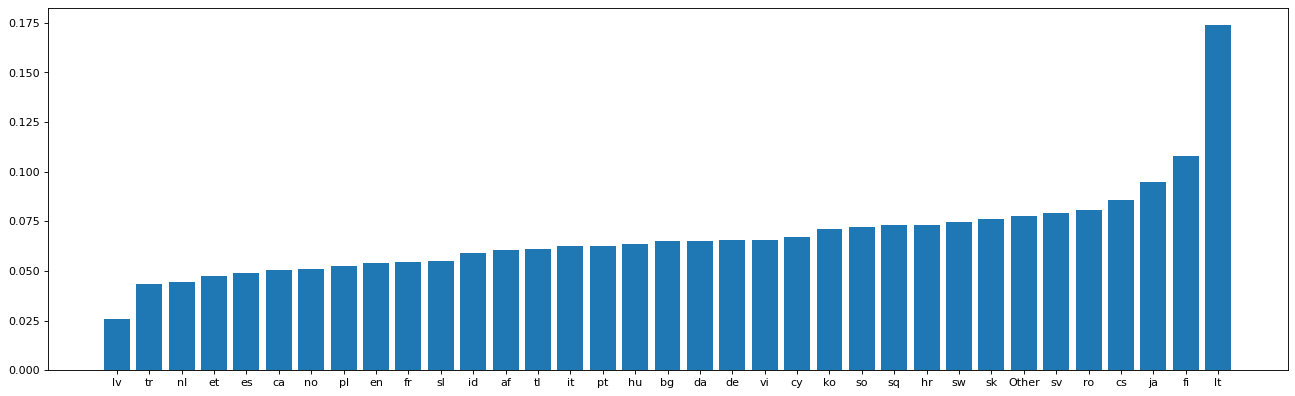

In [ ]:
# find if video is in the language of the top 5 most likeable videos based 
# on video language
train['is_Italian'] = 0
train['is_Finnish'] = 0
train['is_Japanese'] = 0
train['is_Czech'] = 0
train['is_Romanian'] = 0
train["is_Korean"] = 0
#train["is_English"] = 0

figure(figsize=(20, 6), dpi=80)

keys = like.keys()
ratio = {}

for key in like.keys():
  rat = like[key] / count[key]
  ratio[key] = rat
ratio = dict(sorted(ratio.items(), key=lambda item: item[1]))
plt.bar(ratio.keys(), ratio.values())
top_7 = ['Other', 'sv', 'ro', 'cs', 'ja', 'fi', 'lt']

for i in range(len(train)):
  if train['language'][i] == 'lt':
    train['is_Italian'][i]= 1
  elif train['language'][i] == 'fi':
    train['is_Finnish'][i]= 1
  elif train['language'][i] == 'ja':
    train['is_Japanese'][i]= 1
  elif train['language'][i] == 'cs':
    train['is_Czech'][i]= 1
  elif train['language'][i] == 'ro':
    train['is_Romanian'][i]= 1
  elif train["language"][i] == 'ko':
    train['is_Korean'][i]= 1
  else:
    continue

In [ ]:
# create feature is_Thursday, is_Friday, is_Weekend
train['is_Weekend'] = 0
train["is_Thur"] = 0 
train['is_Fri'] = 0

for i in range(len(train)):
  if train['publishedAt'][i].weekday()==4:
    train['is_Thur'][i] = 1
  if train['publishedAt'][i].weekday()==5:
    train['is_Fri'][i] = 1
  if train['publishedAt'][i].weekday()>5:
    train['is_Weekend'][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# transform tags into a list

start = time.time()

for i in range(len(train)):
  train['tags'][i] = str(train['tags'][i]) # convert all objects to string
  x = train['tags'][i]
  train['tags'][i] = x.split("|")

end = time.time()

print("The time of execution of above program is :", end-start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The time of execution of above program is : 174.13226580619812


In [ ]:
# find top 50 most used tags
Dict = {}
for i in range(len(train)):
  for val in train["tags"][i]:
    if val in Dict.keys():
      Dict[val] += 1
    else:
      Dict[val] = 1
ls = sorted(Dict, key=Dict.get, reverse=True)[:50]

In [ ]:
# whether a video is using one of the 50 most used tags or not
train['mostUsedTags']=0

for i in range(len(train)):
  for val in train["tags"][i]:
    if val in ls:
      train['mostUsedTags'][i] = 1
      break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
#start = time.time()

count = {}
for i in range(len(train)):
  for val in ls:
    if val in train["tags"][i]:
      if val in count.keys():
        count[val] += train["view_count"][i]
      else:
        count[val] = train["view_count"][i]

#end = time.time()
#print("The time of execution of above program is :", end-start)

<BarContainer object of 50 artists>

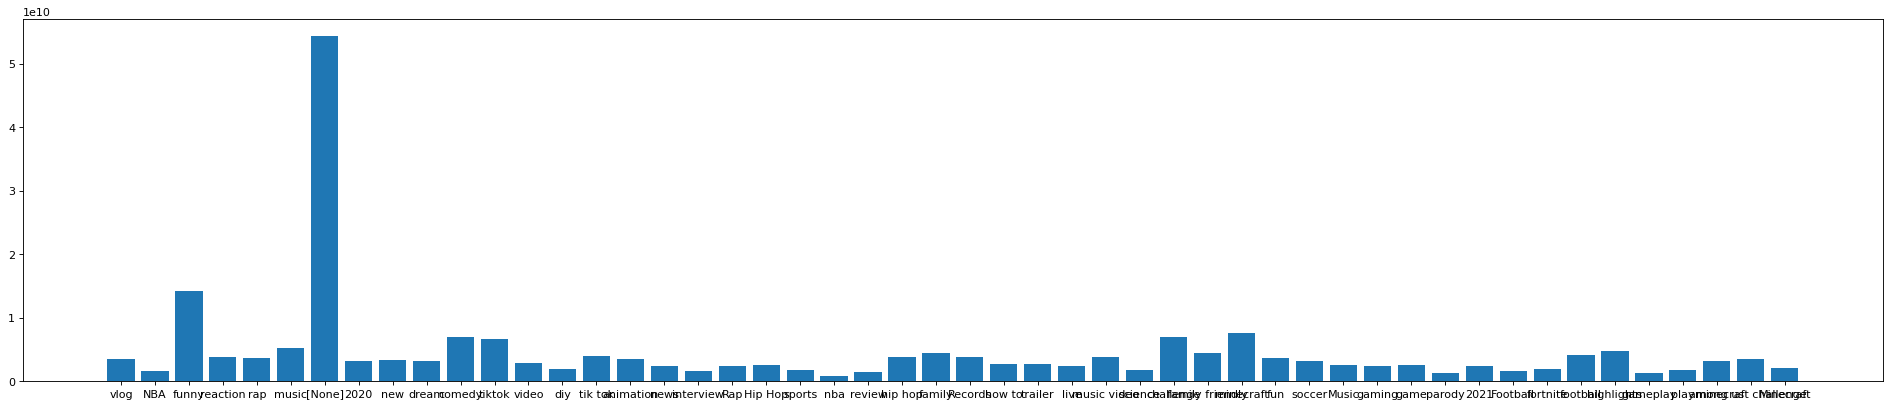

In [ ]:
figure(figsize=(30, 6), dpi=80)
keys = count.keys()
values = count.values()

plt.bar(keys, values)

In [ ]:
likes = {}
for i in range(len(train)):
  for val in ls:
    if val in train["tags"][i]:
      if val in likes.keys():
        likes[val] += train["likes"][i]
      else:
        likes[val] = train["likes"][i]

#end = time.time()
#print("The time of execution of above program is :", end-start)

<BarContainer object of 50 artists>

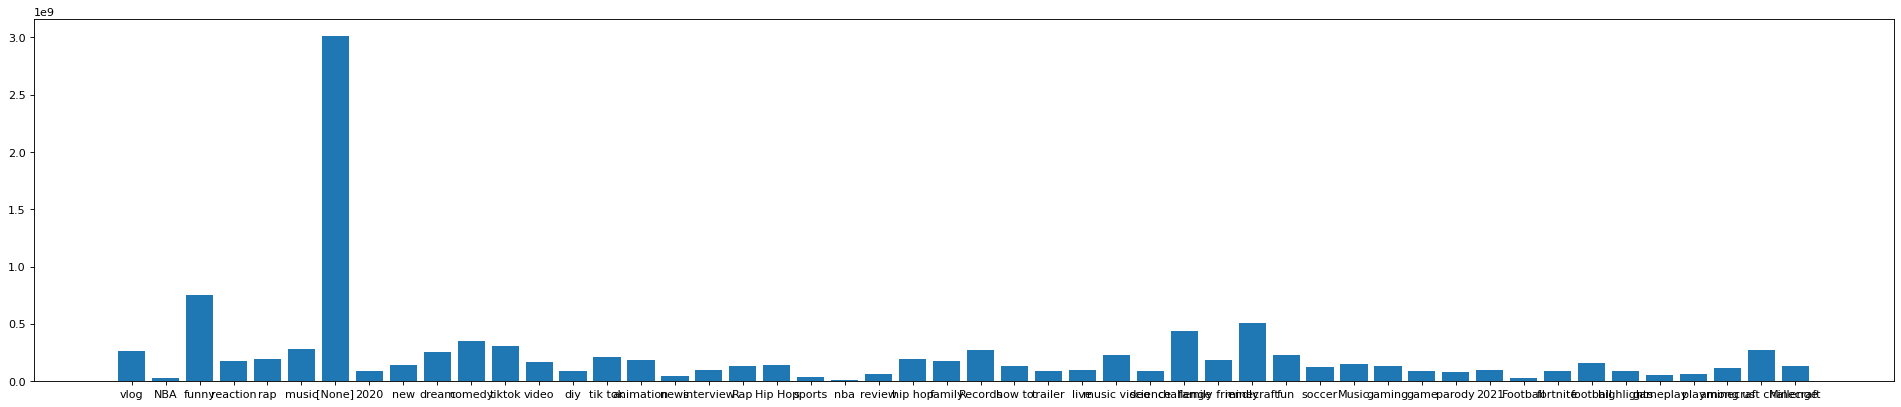

In [ ]:
figure(figsize=(30, 6), dpi=80)
keys = likes.keys()
values = likes.values()

plt.bar(keys, values)

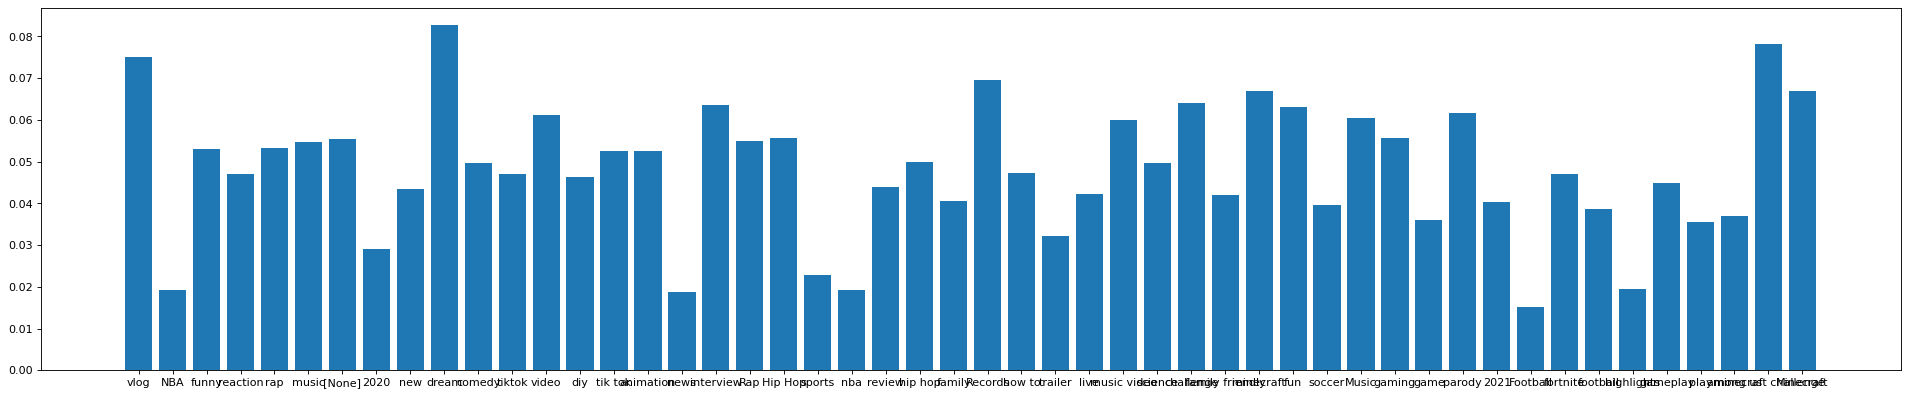

In [ ]:
figure(figsize=(30, 6), dpi=80)

keys = likes.keys()
ratio = []
rank = {}

for key in likes.keys():
  rank[key] = (likes[key] / count[key])
  ratio.append(likes[key] / count[key])

plt.bar(keys, ratio)

lowest_7_tags = sorted(rank, key=rank.get, reverse=False)[:7] #find 5 lowest liked/view
                                                              #ratio tags among top 50 
                                                              #most used tag

In [ ]:
# if used one of the lowest 7 ratio tags, "low_ratio_tags" column = 1, else 0
train['low_ratio_tags'] = 0
for i in range(len(train)):
  for tag in lowest_7_tags:
    if tag in train['tags'][i]:
      train['low_ratio_tags'][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# if duration_seconds is NULL, fill it in with the mean duration_seconds
duration_mean = train["duration_seconds"].mean()

for i in range(len(train)):
  if math.isnan(train["duration_seconds"][i]):
    train["duration_seconds"][i] = duration_mean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# if categoryId is 17 or 25
train["catId_17"] = 0
train["catId_25"] = 0

for i in range(len(train)):
  if train["categoryId"][i] == 17:
    train["catId_17"][i] = 1
    continue
  if train["categoryId"][i] == 25:
    train["catId_25"][i] = 1
    continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
train.columns
features = ['description_length', 'video_age_seconds', 'isShorts', 'tagsCount', 
     'is_top100_channel', 'is_Italian','is_Finnish', 'is_Japanese', 'is_Czech',
     'is_Romanian', 'is_Korean','is_Weekend', 'is_Thur', 'is_Fri', 
     'mostUsedTags', 'low_ratio_tags','catId_17', 'catId_25']

target_1 = "view_count"	
target_2 = "likes" 
target_3 = "target"

In [ ]:
pip install scikit-learn==0.23.2

  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.6 which is incompatible.
pycaret 2.3.10 requires scipy<=1.5.4, but you have scipy 1.7.3 which is incompatible.


In [ ]:
train_pass = train[features]
train_pass["target"] = train[target_3].values

NameError: ignored

In [ ]:
from pycaret.datasets import get_data

from pycaret.regression import *

train_pass = train[features]
train_pass["target"] = train[target_1].values
clf1 = setup(data = train_pass, target = "target")

In [ ]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,2.139254e+06,2.538714e+13,5.026632e+06,0.5161,1.1349,2.0650,23.458
et,Extra Trees Regressor,2.152429e+06,2.597500e+13,5.083690e+06,0.5023,1.1265,2.0181,13.073
lightgbm,Light Gradient Boosting Machine,2.218704e+06,2.683608e+13,5.167784e+06,0.4892,1.1616,2.1160,0.350
gbr,Gradient Boosting Regressor,2.406917e+06,3.586835e+13,5.967301e+06,0.3220,1.2102,2.2828,4.607
dt,Decision Tree Regressor,2.594180e+06,4.670928e+13,6.810987e+06,0.1043,1.3337,2.2277,0.385
ridge,Ridge Regression,2.790016e+06,4.831829e+13,6.919115e+06,0.0949,1.4038,2.5694,0.035
lar,Least Angle Regression,2.790082e+06,4.831837e+13,6.919120e+06,0.0949,1.4043,2.5695,0.037
llar,Lasso Least Angle Regression,2.789888e+06,4.831837e+13,6.919118e+06,0.0949,1.4047,2.5692,0.038
lasso,Lasso Regression,2.790079e+06,4.831837e+13,6.919120e+06,0.0949,1.4042,2.5695,0.631
lr,Linear Regression,2.789979e+06,4.831828e+13,6.919113e+06,0.0949,1.4041,2.5693,0.495


In [ ]:
from pycaret.regression import *
train_pass = train[features]
train_pass["target"] = train[target_3].values
clf1 = setup(data = train_pass, target = "target")

,Description,Value
0,session_id,7129
1,Target,target
2,Original Data,"(91831, 19)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,15
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(64281, 18)"


In [ ]:
best = compare_models()

In [ ]:
from google.colab import files

train.to_csv('train.csv', encoding = 'utf-8-sig') 
files.download('train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Dataaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

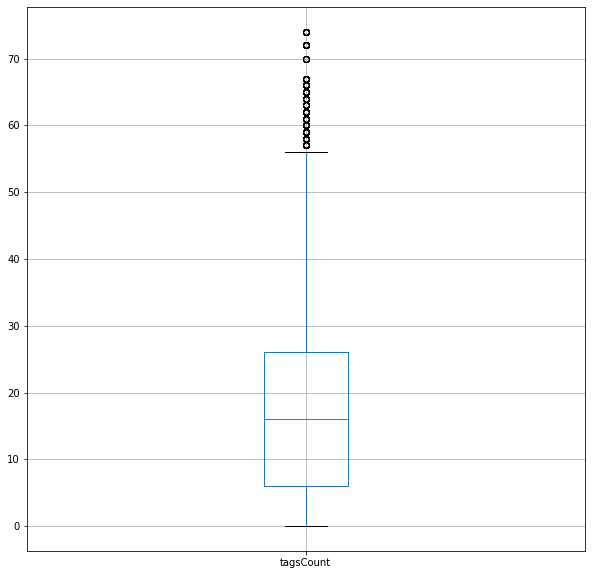

In [ ]:
train.boxplot(column=['tagsCount'],figsize=(10,10))

In [ ]:
train[['duration_seconds','tagsCount','video_age_seconds']].describe()

,duration_seconds,tagsCount,video_age_seconds
count,91831.000000,91831.000000,9.183100e+04
mean,761.387385,16.830275,2.963632e+05
std,5761.296721,12.680292,2.010064e+05
min,3.000000,0.000000,0.000000e+00
25%,186.000000,6.000000,1.541030e+05
50%,481.000000,16.000000,2.828550e+05
75%,845.000000,26.000000,4.238005e+05
max,485620.000000,74.000000,3.120787e+06


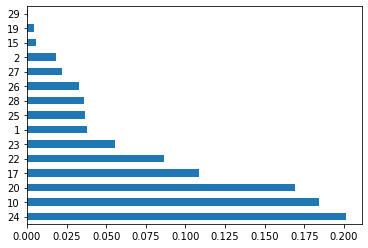

In [ ]:
train.categoryId.value_counts(normalize=True).plot.barh()

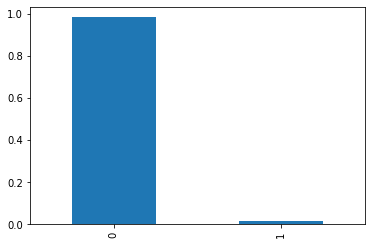

In [ ]:
train.isShorts.value_counts(normalize=True).plot.bar()

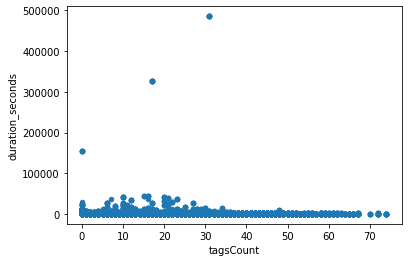

In [ ]:
train.plot.scatter(y='duration_seconds',x='tagsCount')

In [ ]:
ratio

[0.07514008942594932,
 0.019269346279154942,
 0.05295865753991637,
 0.0470051922481939,
 0.053273860343802625,
 0.05470964364244662,
 0.055401270942234765,
 0.029152527687409828,
 0.04339357754930255,
 0.08272543158511345,
 0.04970522929296646,
 0.04692747968611276,
 0.06112096810723665,
 0.0462387562770519,
 0.05253346822714319,
 0.05257667783526077,
 0.01870386832428216,
 0.06357911193752336,
 0.05482361666633977,
 0.05564043381228458,
 0.022927373162283035,
 0.019208410058387915,
 0.043901765292592335,
 0.04979947959224074,
 0.040655040339497364,
 0.06954797638308574,
 0.04724217556181252,
 0.032078861404302814,
 0.04225579685684721,
 0.05986106916687193,
 0.049774766453972094,
 0.06407173739836958,
 0.041919852600206635,
 0.06687749272577255,
 0.06319692971882457,
 0.03956359335969603,
 0.06034877023384006,
 0.0556947688722986,
 0.03595672769206014,
 0.06172880477696555,
 0.04030349174885482,
 0.015146240836039365,
 0.04707386525865227,
 0.03860914973329757,
 0.01946949000368223,
 

In [ ]:
test = pq.read_pandas(test_url).to_pandas()

In [ ]:
print(test.dtypes)

# Exploratory Data Analysis & Data visualization

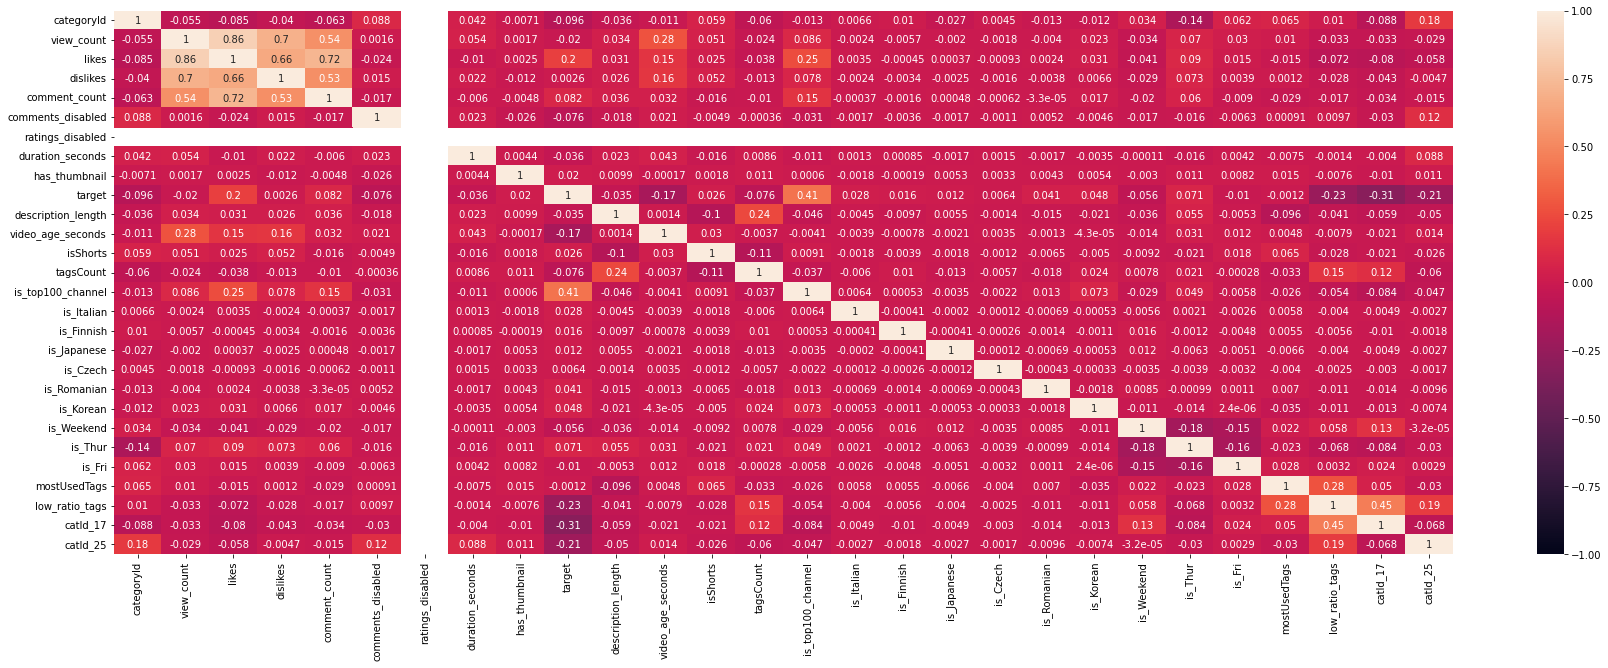

In [ ]:
plt.figure(figsize=(30, 10))

sns.heatmap(train.corr(),vmin=-1, vmax=1, annot=True)

In [ ]:
video_id_group = train.groupby('video_id').filter(lambda x: len(x) >= 12)
print(video_id_group.groupby("video_id").ngroups)
sub = video_id_group.sort_values(by=['target'])[["video_id",
                                                 "video_age_seconds",
                                                 "target"]].groupby([
                                                  "video_id", "video_age_seconds",
                                                  "target"]).size().reset_index()
sub = sub[['video_id', 'video_age_seconds', 'target']]

36


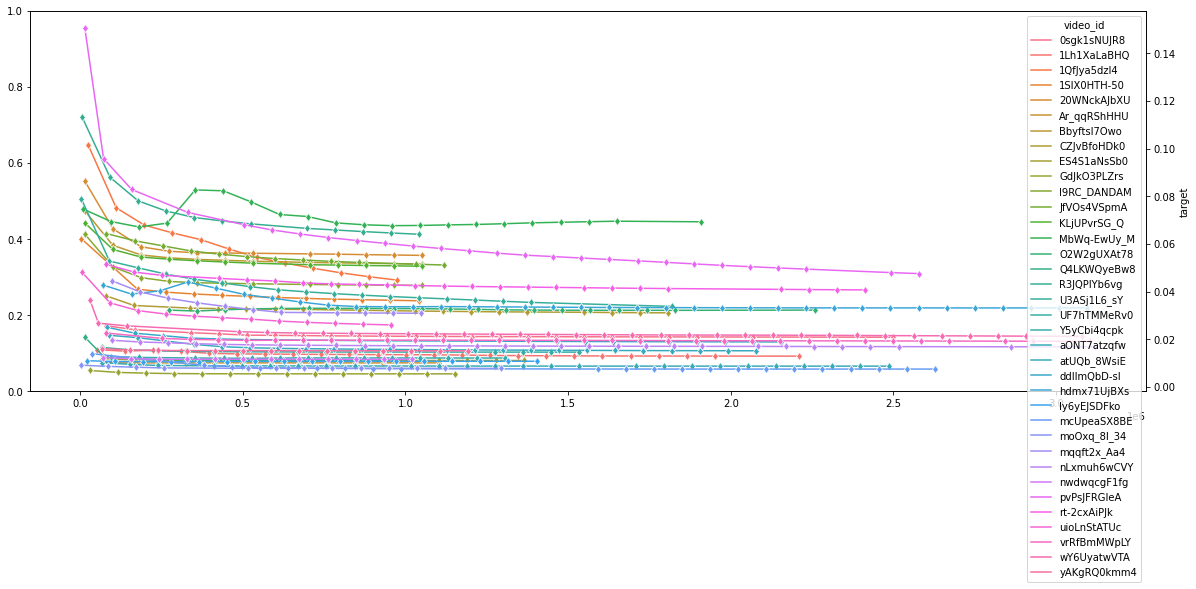

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,7))
ax2=ax1.twinx()

sns.lineplot(x='video_age_seconds',y='target', data=sub, hue='video_id', 
             marker='d', ax=ax2)

    categoryId   size
0            1   3505
1            2   1659
2           10  16930
3           15    496
4           17   9976
5           19    385
6           20  15516
7           22   7943
8           23   5122
9           24  18478
10          25   3380
11          26   3035
12          27   2024
13          28   3299
14          29     83


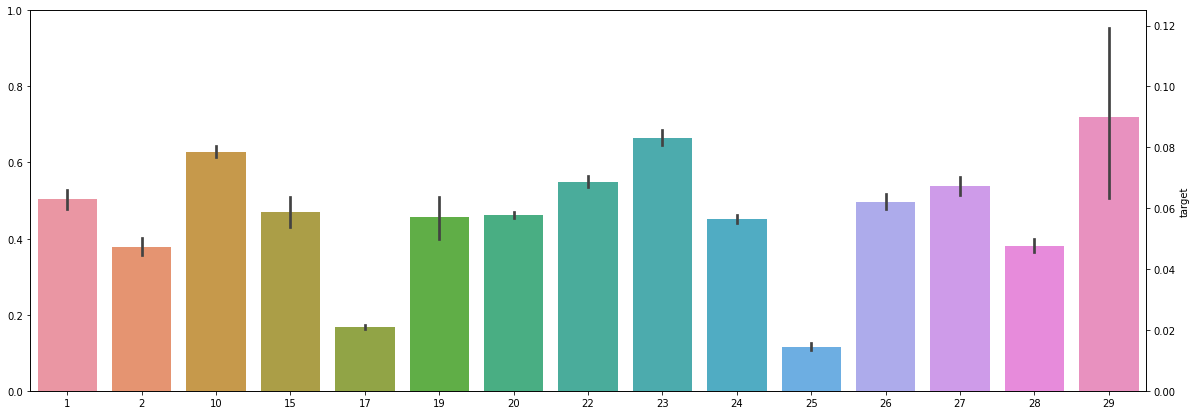

In [ ]:
print(train.groupby(by=["categoryId"],as_index=False).size())
cat_id = train.groupby(by=["title","categoryId"],as_index=False).agg({"target": "mean"}).sort_values(by=["target"],ascending=False)
fig, ax1 = plt.subplots(figsize=(20,7))
ax2=ax1.twinx()
sns.barplot(x='categoryId',y='target', data=cat_id)

In [ ]:
train['language']='blank'

In [ ]:
# !pip install langdetect run once
# !!!!!!run only once!!!!!!!
start = time.time()
from langdetect import detect

def det(x):
    try:
        lang = detect(x)
    except:
        lang = 'Other'
    return lang

end = time.time()
print("The time of execution of above program is :", end - start)

The time of execution of above program is : 0.00020194053649902344


In [ ]:
ct_count = train.groupby(by="LanguageTitle",as_index=False).agg({"target": "mean"}).sort_values(by=["target"],ascending=False).head()
ct_count.loc[:,["LanguageTitle","target"]]

KeyError: ignored

In [ ]:
X=train[['duration_seconds','video_age_seconds','tagsCount']]

In [ ]:
train

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,...,is_Czech,is_Romanian,is_Korean,is_Weekend,is_Thur,is_Fri,mostUsedTags,low_ratio_tags,catId_17,catId_25
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,"[brawadis, prank, basketball, skits, ghost, fu...",1514614,156908,...,0,0,0,0,0,0,1,1,0,0
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,"[Apex Legends, Apex Legends characters, new Ap...",2381688,146739,...,0,0,0,0,0,0,0,0,0,0
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12,"[jacksepticeye, funny, funny meme, memes, jack...",2038853,353787,...,0,0,0,0,0,0,1,0,0,0
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12,"[xxl freshman, xxl freshmen, 2020 xxl freshman...",496771,23251,...,0,0,0,0,0,0,1,0,0,0
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12,"[The LaBrant Family, DIY, Interior Design, Mak...",1123889,45802,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91826,H1tQhK0n5Qk,thanks for 5 million,2021-11-23 19:13:46,UCSUf5_EPEfl4zlBKZHkZdmw,Danny Gonzalez,23,2021-11-30,"[danny gonzalez, funny, commentary, comedy, re...",536056,109352,...,0,0,0,0,0,0,1,0,0,0
91827,3CuO39VL3rk,Mrs. Rogers done F’ed up😅 #shorts #story #come...,2021-11-24 23:48:37,UCqseWqrl7r-hNoWme7hIfTw,Rebecca Rogers (Mrs. Rogers),23,2021-11-30,[[None]],863236,116742,...,0,0,0,0,0,0,1,0,0,0
91828,qfDVsuwg0TU,MY NEW KITCHEN REVEAL!!!!! EXCITING,2021-11-23 22:50:19,UCnB4LOZe6Dc5JUH9EoaHhKQ,Bri & Fern,1,2021-11-30,[10-19-21],194119,14569,...,0,0,0,0,0,0,0,0,0,0
91829,HHbF8HaC4w8,Using Reverse Psychology To Get ANYTHING You Want,2021-11-21 21:15:16,UCQNDoTI2g7_daH6zL_9rvWg,Amyy Woahh,23,2021-11-30,[[None]],24584472,1457618,...,0,0,0,1,0,0,1,0,0,0


In [ ]:
for i in range(len(X['duration_seconds'])):
  if is.n

SyntaxError: ignored

In [ ]:
X['duration_seconds']=X['duration_seconds'].fillna(0)

NameError: ignored

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
print("Explained variance: " + str(pca.explained_variance_)+'\n')
print("Proportion variance: " + str(pca.explained_variance_ratio_)+'\n')
print("Cummulative proportion of variance: " + str(np.cumsum(pca.explained_variance_ratio_))+'\n')
print("top 2 PC score: " + str(pca.singular_values_[:2]))

In [ ]:
import os
df.to_csv(r'/content/drive/MyDrive/IE 7275 Project_YT/Data/train.csv',index = False, header=True)

NameError: ignored

In [ ]:
features.to_csv("C:/Users/hans_/Downloads",'features.csv')

FileNotFoundError: ignored

In [ ]:
from google.colab import files

features.to_csv('features.csv', encoding = 'utf-8-sig') 
files.download('features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
target.to_csv('target.csv',encoding='utf-8-sig')
files.download('target.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-----------------------------Lightgbm feature importance------------------------

In [ ]:
ct_count = train.groupby(["video_id","channelTitle"])#.filter(lambda x: len(x) >= 10)

sub = ct_count.sort_values(by=['target'])[["channelTitle","video_id",
                                                 "target"]].groupby([
                                                  "channelTitle", "video_id",
                                                  "target"]).size().reset_index()
sub = sub[['video_id', 'channelTitle', 'target']].groupby(["video_id","channelTitle"])

AttributeError: ignored

In [ ]:
ct_count = train.groupby(by=["title","categoryId"],as_index=False).agg({"target": "mean"}).sort_values(by=["target"],ascending=False).head(50).reset_index()
ct_count.loc[:,["title","categoryId","target"]]

In [ ]:
# create feature is_korean
ct_count = train.groupby(by="title",as_index=False).agg({"target": "mean"}).sort_values(by=["target"],ascending=False).head(50).reset_index()
ct_count.loc[:,["title","target"]]

In [ ]:
# top50 most "likeable" channels
ct_count = train.groupby(by="channelTitle",as_index=False).agg({"target": "mean"}).sort_values(by=["target"],ascending=False).head(50).reset_index()
ct_count.loc[:,["channelTitle","target"]]

In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(features, target)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

KeyError: ignored

In [ ]:
train.dtypes

video_id                      object
title                         object
publishedAt           datetime64[ns]
channelId                     object
channelTitle                  object
categoryId                     int64
trending_date         datetime64[ns]
tags                          object
view_count                     int64
likes                          int64
dislikes                       int64
comment_count                  int64
thumbnail_link                object
comments_disabled              int64
ratings_disabled               int64
description                   object
id                            object
duration_seconds             float64
has_thumbnail                  int64
target                       float64
description_length           float64
video_age_seconds              int64
isShorts                       int64
tagsCount                    float64
language                      object
is_top100_channel              int64
is_Italian                     int64
i

In [ ]:
features=train.loc[:,['categoryId','comments_disabled','ratings_disabled','duration_seconds','has_thumbnail','description_length','video_age_seconds','isShorts','tagsCount','mostUsedTags','target','is_top100_channel','is_Weekend','is_Thur','is_Fri','mostUsedTags','low_ratio_tags','catId_17','catId_25']]
features['duration_seconds']=features['duration_seconds'].fillna(0)
features[['comments_disabled','ratings_disabled','has_thumbnail','isShorts']]=features[['comments_disabled','ratings_disabled',
          'has_thumbnail','isShorts']].astype(int)
target=features['target']
features=features.drop('target',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
features

,categoryId,comments_disabled,ratings_disabled,duration_seconds,has_thumbnail,description_length,video_age_seconds,isShorts,tagsCount,mostUsedTags,is_top100_channel,is_Weekend,is_Thur,is_Fri,mostUsedTags,low_ratio_tags,catId_17,catId_25
0,22,0,0,0.0,1,361.0,16786,0,15.0,1,0,0,0,0,1,1,0,0
1,20,0,0,0.0,1,715.0,25190,0,25.0,0,0,0,0,0,0,0,0,0
2,24,0,0,0.0,1,513.0,26754,0,30.0,1,1,0,0,0,1,0,0,0
3,10,0,0,0.0,1,762.0,26465,0,23.0,1,0,0,0,0,1,0,0,0
4,26,0,0,0.0,1,2493.0,31795,0,33.0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91826,23,0,0,59.0,1,7.0,535574,0,9.0,1,1,0,0,0,1,0,0,0
91827,23,0,0,58.0,1,0.0,432683,1,0.0,1,0,0,0,0,1,0,0,0
91828,1,0,0,824.0,1,192.0,522581,0,1.0,0,0,0,0,0,0,0,0,0
91829,23,0,0,56.0,1,0.0,701084,0,0.0,1,0,1,0,0,1,0,0,0


In [ ]:
model = RandomForestRegressor()
model.fit(features, target)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature: 0, Score: 0.21369
Feature: 1, Score: 0.00227
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.21739
Feature: 4, Score: 0.01195
Feature: 5, Score: 0.21043
Feature: 6, Score: 0.16440
Feature: 7, Score: 0.00372
Feature: 8, Score: 0.13688
Feature: 9, Score: 0.01745
Feature: 10, Score: 0.02182


NameError: ignored

Feature: 0, Score: 0.21369
Feature: 1, Score: 0.00227
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.21739
Feature: 4, Score: 0.01195
Feature: 5, Score: 0.21043
Feature: 6, Score: 0.16440
Feature: 7, Score: 0.00372
Feature: 8, Score: 0.13688
Feature: 9, Score: 0.01745
Feature: 10, Score: 0.02182


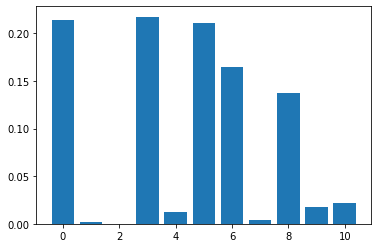

In [ ]:
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [26]:
from google.colab import files
import pandas as pd
import numpy as np

file = files.upload()  #upload file into google colab session
features = pd.read_csv("features.csv") 
features=features.drop([features.columns[0],'mostUsedTags.1','has_thumbnail','ratings_disabled'],axis=1)
#features.rename({'mostUsedTags.1':'mostUsedTags'},axis=1)
features.head()

Saving features.csv to features (2).csv


,categoryId,comments_disabled,duration_seconds,description_length,video_age_seconds,isShorts,tagsCount,mostUsedTags,is_top100_channel,is_Weekend,is_Thur,is_Fri,low_ratio_tags,catId_17,catId_25
0,22,0,0.0,361.0,16786,0,15.0,1,0,0,0,0,1,0,0
1,20,0,0.0,715.0,25190,0,25.0,0,0,0,0,0,0,0,0
2,24,0,0.0,513.0,26754,0,30.0,1,1,0,0,0,0,0,0
3,10,0,0.0,762.0,26465,0,23.0,1,0,0,0,0,0,0,0
4,26,0,0.0,2493.0,31795,0,33.0,0,0,0,0,0,0,0,0


In [2]:
file = files.upload()  #upload file into google colab session
target = pd.read_csv("target.csv") 
target=target.drop(target.columns[0],axis=1)
target.head()

Saving target.csv to target.csv


,target
0,0.103596
1,0.061611
2,0.173523
3,0.046804
4,0.040753


In [ ]:
features.rename({'mostUsedTags.1':'mostUsedTags'},axis=1)

,Unnamed: 0,categoryId,comments_disabled,ratings_disabled,duration_seconds,has_thumbnail,description_length,video_age_seconds,isShorts,tagsCount,mostUsedTags,is_top100_channel,is_Weekend,is_Thur,is_Fri,mostUsedTags,low_ratio_tags,catId_17,catId_25
0,0,22,0,0,0.0,1,361.0,16786,0,15.0,1,0,0,0,0,1,1,0,0
1,1,20,0,0,0.0,1,715.0,25190,0,25.0,0,0,0,0,0,0,0,0,0
2,2,24,0,0,0.0,1,513.0,26754,0,30.0,1,1,0,0,0,1,0,0,0
3,3,10,0,0,0.0,1,762.0,26465,0,23.0,1,0,0,0,0,1,0,0,0
4,4,26,0,0,0.0,1,2493.0,31795,0,33.0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91826,91826,23,0,0,59.0,1,7.0,535574,0,9.0,1,1,0,0,0,1,0,0,0
91827,91827,23,0,0,58.0,1,0.0,432683,1,0.0,1,0,0,0,0,1,0,0,0
91828,91828,1,0,0,824.0,1,192.0,522581,0,1.0,0,0,0,0,0,0,0,0,0
91829,91829,23,0,0,56.0,1,0.0,701084,0,0.0,1,0,1,0,0,1,0,0,0


In [27]:
from sklearn.model_selection import train_test_split
features_train,features_test,target_train,target_test=train_test_split(features,target,test_size=0.25,random_state=1)

In [28]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor

In [ ]:

regr = RandomForestRegressor()
regr.fit(features_train, target_train)

RandomForestRegressor()

In [ ]:
regr.score(features_train,target_train)

0.9559061298147634

In [ ]:
target_pred=regr.predict(features_test)

In [9]:
from sklearn.metrics import r2_score


In [ ]:
r2_score(target_test,target_pred)

0.6927186062601327

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

In [ ]:
estimator = RandomForestRegressor()
param_grid = { 
            "n_estimators"      : [10,20,30,40],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

grid.fit(features_train, target_train)

In [ ]:
grid.best_estimator_

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=30)

In [29]:
regr=RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=30)
regr.fit(features_train, target_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=30)

In [30]:
regr.score(features_train,target_train)

1.0

In [32]:
target_pred=regr.predict(features_test)
r2_score(target_test,target_pred)

0.7689645612271845

In [ ]:
from hpsklearn import HyperoptEstimator
estim = HyperoptEstimator()

# Search the space of classifiers and preprocessing steps and their
# respective hyperparameters in sklearn to fit a model to the data
estim.fit(  x.take(list(train_index),axis=0), target_train )

# Make a prediction using the optimized model
#prediction = estim.predict( unknown_data )

# Report the accuracy of the classifier on a given set of data
#score = estim.score( test_data, test_label )

# Return instances of the classifier and preprocessing steps
#model = estim.best_model()

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]


KeyError: ignored

In [ ]:
features_train.values

array([[20.,  0.,  0., ...,  0.,  0.,  0.],
       [20.,  0.,  0., ...,  0.,  0.,  0.],
       [17.,  0.,  0., ...,  0.,  1.,  0.],
       ...,
       [28.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [28.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
from hyperopt import hp
hp.choice('max_depth',range(1,100))

In [11]:
from sklearn import metrics

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(target_test, target_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(target_test, target_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(target_test, target_pred, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(target_test, target_pred))
print('Explained Variance Score:', metrics.explained_variance_score(target_test, target_pred))
print('Max Error:', metrics.max_error(target_test, target_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(target_test, target_pred))
print('Median Absolute Error:', metrics.median_absolute_error(target_test, target_pred))
print('R^2:', metrics.r2_score(target_test, target_pred))

Mean Absolute Error (MAE): 0.011399986511433768
Mean Squared Error (MSE): 0.00034544429904332866
Root Mean Squared Error (RMSE): 0.018586131901052693
Mean Absolute Percentage Error (MAPE): 0.5317108263659095
Explained Variance Score: 0.7808815189776248
Max Error: 0.2441448475896788
Mean Squared Log Error: 0.0002881570567709655
Median Absolute Error: 0.006475720148096744
R^2: 0.7806808791568974


In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
target_test.describe()

count    22958.000000
mean         0.057241
std          0.040308
min          0.000016
25%          0.028128
50%          0.050795
75%          0.075519
max          0.351383
Name: target, dtype: float64

In [ ]:
pd.Series(target_pred).describe()

count    22958.000000
mean         0.057893
std          0.030913
min          0.000155
25%          0.041433
50%          0.055579
75%          0.070421
max          0.302555
dtype: float64

In [ ]:
train_pass=train_pass.drop(['target'],axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
features_train,features_test,target_train,target_test=train_test_split(train_pass,target,test_size=0.25)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor()
regr.fit(features_train, target_train)

AdaBoostRegressor()

In [ ]:
regr.score(features_train,target_train)

0.05852600126033347

In [ ]:
target_pred=regr.predict(features_test)
r2_score(target_test,target_pred)

0.04303901494011375

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
regr = AdaBoostRegressor()
regr.fit(features_train, target_train)

AdaBoostRegressor()

In [ ]:
regr.score(features_train,target_train)

0.13506674107707628

In [ ]:
target_pred=regr.predict(features_test)
r2_score(target_test,target_pred)

0.11461240718600496

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                          for i in range(len(features.columns))]
  
print(vif_data)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1638: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


               feature       VIF
0           categoryId  5.865121
1    comments_disabled  1.037967
2     ratings_disabled       NaN
3     duration_seconds  1.029062
4        has_thumbnail  5.646947
5   description_length  2.360388
6    video_age_seconds  2.881667
7             isShorts  1.045629
8            tagsCount  2.894534
9         mostUsedTags  2.238605
10   is_top100_channel  1.072480
11          is_Weekend  1.252983
12             is_Thur  1.282624
13              is_Fri  1.201061
14      low_ratio_tags  1.626078
15            catId_17  1.500350
16            catId_25  1.191588


In [24]:
features[['ratings_disabled']].value_counts()

ratings_disabled
0                   91831
dtype: int64

In [25]:
features[['ratings_disabled']]

,ratings_disabled
0,0
1,0
2,0
3,0
4,0
...,...
91826,0
91827,0
91828,0
91829,0
